In [275]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
#from scikitplot.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

In [276]:
def showInformation(df):
  print('\n shape of data : \n', df.shape)
  print('\n columns : \n',df.columns)
  print('\n dataset info : \n', df.info())
  print('\n dataset datatypes : \n', df.dtypes)
  if df.isnull().values.any():
    print('\n sum of null values : \n' , df.isnull().sum())
  else:
    print("\n This dataset has no null values amongst its features.")

def getdataCount(columns,df):
  for column in columns:
    print('\n {} : \n {}'.format(column,df[column].value_counts()))

def getUniqueValue(columns,df):
  for column in columns:
    print('\n {} : \n {}'.format(column,df[column].unique()))

def checkifUnkown(df):
  features = df.columns
  for feature in features:
    if((df[feature] =='-unknown-').any() ) :
      print(feature)

# Feature Engineering Functions

In [277]:
def session_features(df):
    df['total_seconds'] = df['id'].apply(lambda x: total_seconds[x] if x in total_seconds else 0)
    df['average_seconds'] = df['id'].apply(lambda x: average_seconds[x] if x in average_seconds else 0)
    df['total_sessions'] = df['id'].apply(lambda x: total_sessions[x] if x in total_sessions else 0)
    df['distinct_sessions'] = df['id'].apply(lambda x: distinct_sessions[x] if x in distinct_sessions else 0)
    df['num_short_sessions'] = df['id'].apply(lambda x: num_short_sessions[x] if x in num_short_sessions else 0)
    df['num_long_sessions'] = df['id'].apply(lambda x: num_long_sessions[x] if x in num_long_sessions else 0)
    df['num_devices'] = df['id'].apply(lambda x: num_devices[x] if x in num_devices else 0)
    return df

def browsers(df):
    df['first_browser'] = df['first_browser'].apply(lambda x: "Mobile_Safari" if x == "Mobile Safari" else x)
    major_browsers = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile_Safari']
    df['first_browser'] = df['first_browser'].apply(lambda x: 'Other' if x not in major_browsers else x)
    return df

def classify_device(x):
    if x.find('Desktop') != -1:
        return 'Desktop'
    elif x.find('Tablet') != -1 or x.find('iPad') != -1:
        return 'Tablet'
    elif x.find('Phone') != -1:
        return 'Phone'
    else:
        return 'Unknown'

def devices(df):
    df['first_device_type'] = df['first_device_type'].apply(classify_device)
    return df

def affiliate_tracked(df):
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].fillna('Unknown')
    df['first_affiliate_tracked'] = df['first_affiliate_tracked'].apply(lambda x: 'Other' if x != 'Unknown' and x != 'untracked' else x)
    return df

def affiliate_provider(df):
    df['affiliate_provider'] = df['affiliate_provider'].apply(lambda x: 'rest' if x not in ['direct', 'google', 'other'] else x)
    return df

def affiliate_channel(df):
    df['affiliate_channel'] = df['affiliate_channel'].apply(lambda x: 'other' if x  not in ['direct', 'content'] else x)
    return df

def languages(df):
    df['language'] = df['language'].apply(lambda x: 'foreign' if x != 'en' else x)
    return df

def first_booking(df):
    df = df.drop('date_first_booking', axis=1)
    return df
def account_created(df):
    df = df.drop('date_account_created', axis=1)
    return df

In [278]:
def set_age_group(x):
    if x < 40:
        return 'Young'
    elif x >=40 and x < 60:
        return 'Middle'
    elif x >= 60 and x <= 125:
        return 'Old'
    else:
        return 'Unknown'

## Do feature dunction

In [279]:
def feature_engineering(df):
    df = session_features(df)
    df = df.drop('age', axis=1)
    df = browsers(df)
    df =devices(df)
    df =affiliate_tracked(df)
    df = affiliate_provider(df)
    df = affiliate_channel(df)
    df = languages(df)
    df['is_3'] = df['signup_flow'].apply(lambda x: 1 if x==3 else 0)
    df = first_booking(df)
    df = df.drop('timestamp_first_active', axis=1)
    df = account_created(df)
    df = df.set_index('id')
    df = pd.get_dummies(df, prefix='is')
    return df

# Feature Engineering

## Merge data 

In [280]:
df_train = pd.read_csv('/content/drive/My Drive/vodafoneTask/datasets/dataset-modified/train_users-V1.csv')
df_test = pd.read_csv('/content/drive/My Drive/vodafoneTask/datasets/test_users.csv')
df_sessions = pd.read_csv('/content/drive/My Drive/vodafoneTask/datasets/dataset-modified/sessions-v1.csv')
df_train.shape, df_test.shape

((213451, 16), (62096, 15))

In [281]:
median_secs = df_sessions['secs_elapsed'].median()
df_sessions['secs_elapsed'] = df_sessions['secs_elapsed'].fillna(median_secs)

In [282]:
df_sessions.rename(columns = {'user_id': 'id'}, inplace=True)

In [283]:
df_sessions['device_type'] = df_sessions['device_type'].replace('-unknown-', np.nan)

In [284]:
total_seconds = df_sessions.groupby('id')['secs_elapsed'].sum()
average_seconds = df_sessions.groupby('id')['secs_elapsed'].mean()
total_sessions = df_sessions.groupby('id')['action'].count()
distinct_sessions = df_sessions.groupby('id')['action'].nunique()
num_short_sessions = df_sessions[df_sessions['secs_elapsed'] <= 300].groupby('id')['action'].count()
num_long_sessions = df_sessions[df_sessions['secs_elapsed'] >= 2000].groupby('id')['action'].count()
num_devices = df_sessions.groupby('id')['device_type'].nunique()

In [285]:
df_train = session_features(df_train)

In [286]:
df_train['age_group'] = df_train['age'].apply(set_age_group)


In [287]:
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,distinct_sessions,num_short_sessions,num_long_sessions,num_devices,age_group
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,0.0,0.0,0,0,0,0,0,Unknown
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,0.0,0.0,0,0,0,0,0,Young
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,0.0,0.0,0,0,0,0,0,Middle
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,0.0,0.0,0,0,0,0,0,Middle
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,0.0,0.0,0,0,0,0,0,Middle


In [288]:
df_train = df_train.drop('age', axis=1)
df_train = browsers(df_train)
df_train = devices(df_train)
df_train = affiliate_tracked(df_train)
df_train = affiliate_provider(df_train)
df_train = affiliate_channel(df_train)
df_train = languages(df_train)
df_train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,distinct_sessions,num_short_sessions,num_long_sessions,num_devices,age_group
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,NaN,facebook,0,en,direct,direct,untracked,Web,Desktop,Chrome,NDF,0.0,0.0,0,0,0,0,0,Unknown
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,facebook,0,en,other,google,untracked,Web,Desktop,Chrome,NDF,0.0,0.0,0,0,0,0,0,Young
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,basic,3,en,direct,direct,untracked,Web,Desktop,IE,US,0.0,0.0,0,0,0,0,0,Middle
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,facebook,0,en,direct,direct,untracked,Web,Desktop,Firefox,other,0.0,0.0,0,0,0,0,0,Middle
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,NaN,basic,0,en,direct,direct,untracked,Web,Desktop,Chrome,US,0.0,0.0,0,0,0,0,0,Middle


In [289]:
df_train['is_0'] = df_train['signup_flow'].apply(lambda x: 1 if x==0 else 0)
df_train['gender'] = df_train['gender'].fillna('Unknown')
df_train = first_booking(df_train)
df_train = df_train.drop('timestamp_first_active', axis=1)
df_train = account_created(df_train)
df_train = df_train.set_index('id')
df_train.head()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,total_seconds,average_seconds,total_sessions,distinct_sessions,num_short_sessions,num_long_sessions,num_devices,age_group,is_0
id,,,,,,,,,,,,,,,,,,,,
gxn3p5htnn,Unknown,facebook,0,en,direct,direct,untracked,Web,Desktop,Chrome,NDF,0.0,0.0,0,0,0,0,0,Unknown,1
820tgsjxq7,MALE,facebook,0,en,other,google,untracked,Web,Desktop,Chrome,NDF,0.0,0.0,0,0,0,0,0,Young,1
4ft3gnwmtx,FEMALE,basic,3,en,direct,direct,untracked,Web,Desktop,IE,US,0.0,0.0,0,0,0,0,0,Middle,0
bjjt8pjhuk,FEMALE,facebook,0,en,direct,direct,untracked,Web,Desktop,Firefox,other,0.0,0.0,0,0,0,0,0,Middle,1
87mebub9p4,Unknown,basic,0,en,direct,direct,untracked,Web,Desktop,Chrome,US,0.0,0.0,0,0,0,0,0,Middle,1


In [290]:
df_train = df_train[df_train['country_destination']!='NDF']

### Split data and convert object data to numerical

In [291]:
class_dict = {
    'US': 1,
    'other': 2,
    'FR': 3,
    'CA': 4,
    'GB': 5,
    'ES': 6,
    'IT': 7,
    'PT': 8,
    'NL': 9,
    'DE': 10,
    'AU': 11
}
X, y = df_train.drop('country_destination', axis=1), df_train['country_destination'].apply(lambda x: class_dict[x])

In [292]:
X.age_group.unique()

array(['Middle', 'Unknown', 'Young', 'Old'], dtype=object)

In [293]:
age_group = {
    'Unknown': 0,
    'Young': 1,
    'Middle': 2,
    'Old': 3
}
X['age_group']= X['age_group'].apply(lambda x: age_group[x])

In [294]:
first_browser = {
    'Other': 0,
    'Chrome': 1,
    'IE': 2,
    'Firefox': 3,
    'Safari':4,
    'Mobile_Safari':5
}
X['first_browser']= X['first_browser'].apply(lambda x: first_browser[x])

In [295]:
first_device_type = {
    'Unknown': 0,
    'Desktop': 1,
    'Phone': 2,
    'Tablet': 3
}
X['first_device_type']= X['first_device_type'].apply(lambda x: first_device_type[x])


In [296]:
signup_app = {
    'Web': 0,
    'Moweb': 1,
    'iOS': 2,
    'Android': 3
}
X['signup_app']= X['signup_app'].apply(lambda x: signup_app[x])


In [297]:
first_affiliate_tracked = {
    'untracked': 0,
    'Other': 1,
    'Unknown': 2
}
X['first_affiliate_tracked']= X['first_affiliate_tracked'].apply(lambda x: first_affiliate_tracked[x])


In [298]:
affiliate_provider = {
    'direct': 0,
    'google': 1,
    'other': 2,
    'rest': 3
}
X['affiliate_provider']= X['affiliate_provider'].apply(lambda x: affiliate_provider[x])


In [299]:
affiliate_channel = {
    'direct': 0,
    'other': 1,
    'content': 2
}
X['affiliate_channel']= X['affiliate_channel'].apply(lambda x: affiliate_channel[x])


In [300]:
signup_method = {
    'facebook': 0,
    'basic': 1,
    'google': 2
}
X['signup_method']= X['signup_method'].apply(lambda x: signup_method[x])


In [301]:
gender = {
    'Unknown': 0,
    'MALE': 1,
    'FEMALE': 2,
    'OTHER' : 3
}
X['gender']= X['gender'].apply(lambda x: gender[x])


In [302]:
language = {
    'en': 0,
    'foreign': 1
}
X['language']= X['language'].apply(lambda x: language[x])
X.head()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,total_seconds,average_seconds,total_sessions,distinct_sessions,num_short_sessions,num_long_sessions,num_devices,age_group,is_0
id,,,,,,,,,,,,,,,,,,,
4ft3gnwmtx,2,1,3,0,0,0,0,0,1,2,0.0,0.0,0,0,0,0,0,2,0
bjjt8pjhuk,2,0,0,0,0,0,0,0,1,3,0.0,0.0,0,0,0,0,0,2,1
87mebub9p4,0,1,0,0,0,0,0,0,1,1,0.0,0.0,0,0,0,0,0,2,1
osr2jwljor,0,1,0,0,1,2,1,0,1,1,0.0,0.0,0,0,0,0,0,0,1
lsw9q7uk0j,2,1,0,0,1,3,0,0,1,4,0.0,0.0,0,0,0,0,0,2,1


## Normalizing Numerical Features

In [303]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 71126 samples.
Testing set has 17782 samples.


In [304]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[0.        , 0.5       , 0.        , ..., 0.16666667, 0.        ,
        1.        ],
       [0.66666667, 0.        , 0.        , ..., 0.        , 0.66666667,
        1.        ],
       [0.66666667, 0.5       , 0.        , ..., 0.        , 0.33333333,
        1.        ],
       ...,
       [0.33333333, 0.5       , 0.        , ..., 0.        , 0.33333333,
        1.        ],
       [0.66666667, 0.        , 0.        , ..., 0.        , 0.33333333,
        1.        ],
       [0.66666667, 0.5       , 0.        , ..., 0.        , 0.66666667,
        1.        ]])

In [305]:
y_train

id
sczbzagsel    1
ob4ms2sdyb    1
nzd9fxvn5x    1
ml2pdvxyyp    1
8wyxo056hk    1
             ..
i3uhfnignp    1
s2s2bul0i1    1
o9j9dp8pzb    7
z4h195n31q    1
q53ngxgafb    1
Name: country_destination, Length: 71126, dtype: int64

In [306]:
y_train_scaled = y_train.reset_index(drop=True)
y_train_scaled

0        1
1        1
2        1
3        1
4        1
        ..
71121    1
71122    1
71123    7
71124    1
71125    1
Name: country_destination, Length: 71126, dtype: int64

In [307]:
y_test_scaled = y_test.reset_index(drop=True)
y_test_scaled

0         7
1         1
2         1
3         1
4         1
         ..
17777    10
17778     2
17779     3
17780     1
17781     2
Name: country_destination, Length: 17782, dtype: int64

In [308]:
X_train.head()

,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,total_seconds,average_seconds,total_sessions,distinct_sessions,num_short_sessions,num_long_sessions,num_devices,age_group,is_0
id,,,,,,,,,,,,,,,,,,,
sczbzagsel,0,1,0,0,0,0,0,0,1,3,0.0,0.0,0,0,0,0,0,0,1
ob4ms2sdyb,0,1,3,0,1,1,0,0,1,4,0.0,0.0,0,0,0,0,0,2,0
nzd9fxvn5x,1,0,0,0,0,0,1,0,1,3,0.0,0.0,0,0,0,0,0,1,1
ml2pdvxyyp,1,0,0,0,0,0,0,0,1,2,0.0,0.0,0,0,0,0,0,1,1
8wyxo056hk,1,0,0,0,0,0,0,0,1,3,51157.0,10231.4,3,2,1,1,1,1,1


In [309]:
pd.DataFrame(X_train_scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000000,0.5,0.00,0.0,0.0,0.000000,0.0,0.0,0.333333,0.6,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
1,0.000000,0.5,0.12,0.0,0.5,0.333333,0.0,0.0,0.333333,0.8,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.0
2,0.333333,0.0,0.00,0.0,0.0,0.000000,0.5,0.0,0.333333,0.6,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,1.0
3,0.333333,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.333333,0.4,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,1.0
4,0.333333,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.333333,0.6,0.00192,0.011596,0.001325,0.032258,0.001013,0.001531,0.166667,0.333333,1.0


## Implementation - Creating a Training and Predicting Pipeline

In [310]:
def train_predict(classifier):
  print(classifier)
  results = {}
    # Fit the classifier to the training data and Calculate the time
  start_train = time()
  classifier = classifier.fit(X_train_scaled, y_train_scaled)
  end_train = time()
  results['train_time'] = round((end_train-start_train), 2)
  print(results)
  # Predict the training/testing labels and Calculate the time
  start_test = time()
  y_pred_train = classifier.predict(X_train_scaled)
  y_pred_test = classifier.predict(X_test_scaled)
  end_test = time()   
  results['pred_time'] = round((end_test-start_test), 2)
  # Model evaluation (training/testing data) using accuracy
  results['acc_train'] = round(accuracy_score(y_train_scaled, y_pred_train), 2)
  results['acc_test'] = round(accuracy_score(y_test_scaled, y_pred_test), 2)
  # Model evaluation (training/testing data) using f1-score
  results['f1_train'] = round(f1_score(y_train_scaled, y_pred_train,average='micro'), 2)
  results['f1_test'] = round(f1_score(y_test_scaled, y_pred_test,average='micro'), 2)
  print(results['f1_train']) 
    # Display classification_report
  report = classification_report(y_test_scaled, y_pred_test)
       
    
    # Return the results
  return results, report 

    

In [311]:
# Initialize the classifiers
clf_KN = KNeighborsClassifier(n_neighbors=6)
clf_RF = RandomForestClassifier(max_depth=2, random_state=0)
clf_xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)
clf_list = [clf_KN, clf_RF, clf_xgb]

# Compare evaluation of the different classifiers
clf_evaluation = {}
clf_report = {}

for clf in clf_list:
  clf_evaluation[clf.__class__.__name__] = train_predict(clf)[0]
  clf_report[clf.__class__.__name__] = train_predict(clf)[1]

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')
{'train_time': 3.42}
0.7
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')
{'train_time': 3.66}
0.7
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
{'train_time': 2.04}
0.7
RandomFore

In [312]:
clf_evaluation

{'KNeighborsClassifier': {'acc_test': 0.69,
  'acc_train': 0.7,
  'f1_test': 0.69,
  'f1_train': 0.7,
  'pred_time': 65.02,
  'train_time': 3.42},
 'RandomForestClassifier': {'acc_test': 0.7,
  'acc_train': 0.7,
  'f1_test': 0.7,
  'f1_train': 0.7,
  'pred_time': 0.96,
  'train_time': 2.04},
 'XGBClassifier': {'acc_test': 0.7,
  'acc_train': 0.7,
  'f1_test': 0.7,
  'f1_train': 0.7,
  'pred_time': 1.44,
  'train_time': 19.69}}

In [314]:
print(clf_report['KNeighborsClassifier'])

              precision    recall  f1-score   support

           1       0.70      0.98      0.82     12448
           2       0.15      0.01      0.03      2000
           3       0.11      0.01      0.02      1016
           4       0.00      0.00      0.00       275
           5       0.00      0.00      0.00       455
           6       0.00      0.00      0.00       459
           7       0.00      0.00      0.00       591
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00       168
          10       0.00      0.00      0.00       206
          11       0.00      0.00      0.00       115

    accuracy                           0.69     17782
   macro avg       0.09      0.09      0.08     17782
weighted avg       0.51      0.69      0.58     17782



In [315]:
print(clf_report['RandomForestClassifier'])

              precision    recall  f1-score   support

           1       0.70      1.00      0.82     12448
           2       0.00      0.00      0.00      2000
           3       0.00      0.00      0.00      1016
           4       0.00      0.00      0.00       275
           5       0.00      0.00      0.00       455
           6       0.00      0.00      0.00       459
           7       0.00      0.00      0.00       591
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00       168
          10       0.00      0.00      0.00       206
          11       0.00      0.00      0.00       115

    accuracy                           0.70     17782
   macro avg       0.06      0.09      0.07     17782
weighted avg       0.49      0.70      0.58     17782



In [316]:
print(clf_report['XGBClassifier'])

              precision    recall  f1-score   support

           1       0.70      1.00      0.82     12448
           2       0.14      0.00      0.00      2000
           3       0.00      0.00      0.00      1016
           4       0.00      0.00      0.00       275
           5       0.00      0.00      0.00       455
           6       0.00      0.00      0.00       459
           7       0.50      0.00      0.00       591
           8       0.00      0.00      0.00        49
           9       0.00      0.00      0.00       168
          10       0.00      0.00      0.00       206
          11       0.00      0.00      0.00       115

    accuracy                           0.70     17782
   macro avg       0.12      0.09      0.08     17782
weighted avg       0.52      0.70      0.58     17782



In [317]:
legend = []
for i in range(len(clf_list)):
    legend.append(clf_list[i].__class__.__name__)

In [318]:
def eval_plot(labels, y_label, title):

    clf1 = [clf_evaluation[legend[0]][labels[0]], clf_evaluation[legend[0]][labels[1]]]
    clf2 = [clf_evaluation[legend[1]][labels[0]], clf_evaluation[legend[1]][labels[1]]]
    clf3 = [clf_evaluation[legend[2]][labels[0]], clf_evaluation[legend[2]][labels[1]]]

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots()
    ax.bar(x - width/2, clf1, width, label=legend[0])
    ax.bar(x + width/2, clf2, width, label=legend[1])
    ax.bar(x + width*3/2, clf3, width, label=legend[2])

    # Add labels, title, and legend
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Add bars annotation
    for i in ax.patches:
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x()+(width/2), i.get_height()+0.01,
                str(i.get_height()), fontsize=11,
                color='black', ha='center')

    plt.show()

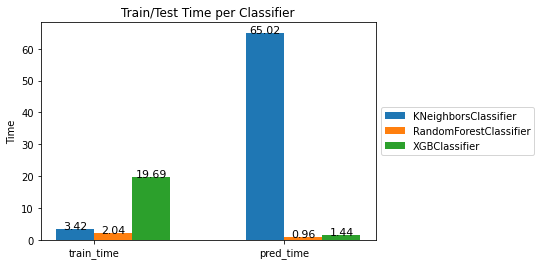

In [319]:
labels = ['train_time', 'pred_time']
y_label = 'Time'
title = 'Train/Test Time per Classifier'
eval_plot(labels, y_label, title)

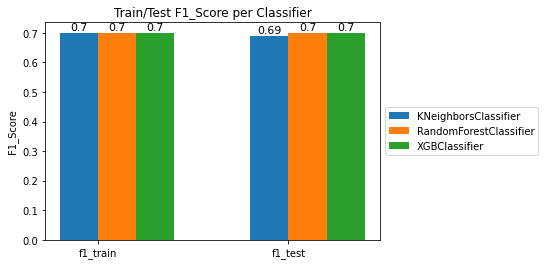

In [320]:
labels = ['f1_train', 'f1_test']
y_label = 'F1_Score'
title = 'Train/Test F1_Score per Classifier'
eval_plot(labels, y_label, title)